# Benchmark Experiments Logs Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logs_parser
import os
import subprocess

# Experiments Log Paths
Relative logs path from this notebook location

In [2]:
cwd = os.getcwd()
subscriber_logs = f'{cwd}/../subscriber/logs/'
publishers_logs = f'{cwd}/../publisher/logs/'
transformer_logs= f'{cwd}/../transformer/logs/'

# Benchmark Parameters
Benchmark parameters used in the setup for execution of the system under test.

In [3]:
auts=['aut1','aut2','aut3']
qoss =['qos0', 'qos1', 'qos2']
gateways=['provider1.gateway1','provider1.gateway2','provider2.gateway1']
# Topics prefix
providers_tp=['site1/provider1','site1/provider2']  
gateway_topics=['site1/provider1/gateway1','site1/provider1/gateway2','site1/provider2/gateway1']

# Benchmark Setups Evalutated
Iterate over the benchmark setups using the experiments log folders structure.

Architectural Options Under Test (AUT):
- **AUT1.15b** - Architectural Option 1: One bridge transformer per data provider (total of 2 transformers deployed)
- **AUT1.29b** - Architectural Option variation: After the benchmark results analysis, further data was needed to investigate the topic name overhead between AUT1 and AUT2. We conducted a third exeperiement mapping the topic names from the ingestion broker (source), and the destination broker to which the subscriber connects with
- **AUT2** - Architectural Option 2: One bridge transformer per sensor hub data stream (total of 4 transformers deployed)

MQTT Clients end-to-end Quality-of-Service (QoS):
- **QoS 0** - At most once: prone to message lost
- **QoS 1** - At least once: prone to duplicated message delivery
- **QoS 2** - Exactly once: message delivery guarantee

## Setups (9):
1. AUT1.15b - QoS 0
2. AUT1.15b - QoS 1
3. AUT1.15b - QoS 2
4. AUT1.29b - QoS 0
8. AUT1.29b - QoS 1
9. AUT1.29b - QoS 2
5. AUT2 - QoS 0
6. AUT2 - QoS 1
7. AUT2 - QoS 2
   

# Global Results - Table IV
Arithmethic means of all repetitions per execution of each benchmark setup listed above

In [4]:
%load_ext autoreload
%autoreload 2

# Define a custom dtype for the structured array
dtype = [('timestamp','datetime64[s]'), ('uuid', 'U64'), ('latency', 'f8'), ('topic', 'U64'), ('payload_size', 'i4'), ('topic_size', 'i4'), ('order', 'i4'),('aut','U64'),('qos','U64'),('gateway','U64')]

# Convert to NumPy structured array
np_array_global = np.empty(0, dtype=dtype)

total_log_entries=0
for aut in auts:
    for qos in qoss:
        aut_pub_log_folder = os.path.join(publishers_logs, aut, qos)
        aut_sub_log_folder = os.path.join(subscriber_logs, aut, qos)
        aut_trans_log_folder = os.path.join(transformer_logs, aut, qos)
        stats_file='.'.join((('_'.join(('stats',aut,qos))),'txt'))
        stats=os.path.join(aut_sub_log_folder, stats_file)

        print(f'\n{aut.upper()}/{qos.upper()}\t\n')
        print(f'Publisher folder: {aut_pub_log_folder} \nSubscriber folder: {aut_sub_log_folder}\nStats file: {stats}')

        load = logs_parser.get_sub_logs(aut_sub_log_folder)

        if len(load) == 0:
            continue

        try:
            # Run the command
            pub_command = f"grep -rnw \"rc: Success\" {aut_pub_log_folder} | wc -l"
            published_msgs_provider1 = int(subprocess.check_output(pub_command, shell=True, text=True))
            pub_command = f"grep -rnw \"rc: Success\" {aut_pub_log_folder} | wc -l"
            published_msgs_provider2 = int(subprocess.check_output(pub_command, shell=True, text=True)) * 2  # 2 messages published per iteration

            # Print the output
            print(f"Provider 1 publish count:{published_msgs_provider1}")
            print(f"Provider 2 publish count:{published_msgs_provider2}")
        except subprocess.CalledProcessError as e:
            print(f"An error occurred: {e}")

            
        dates = logs_parser.get_pub_exec_datetimes(aut_pub_log_folder)
        trans_array = logs_parser.get_trans_logs(aut_trans_log_folder)
        np_array=logs_parser.get_numpy_array(load, trans_array, dates)

        total_log_entries+=len(np_array)

        new_array = np.empty(np_array.shape, dtype=dtype)
        
        # Copy existing data into the new array
        for name in np_array.dtype.names:
            new_array[name] = np_array[name]

        # Fill the new columns with the desired values
        new_array['aut'] = aut
        new_array['qos'] = qos

        np_array_global=np.concatenate((np_array_global,new_array))
        
        delay = logs_parser.get_np_stats(np_array['latency'])

        rcv_msgs=len(np_array)
        avg_rcv_msgs = rcv_msgs/ logs_parser.NUM_RUNS
        
        uniques = np.sum(np.unique_counts(np_array['uuid']).counts)
        duplicates_count = rcv_msgs - uniques
        avg_duplicates   = duplicates_count / logs_parser.NUM_RUNS
        
        lost_msgs=logs_parser.get_lost_messages(load)
        avg_lost_msg = (lost_msgs - duplicates_count)/ logs_parser.NUM_RUNS 

        # Global topic sizes
        topic_size = logs_parser.get_np_stats(np_array['topic_size'])
        
        # Global Payload sizes
        payload=logs_parser.get_np_stats(np_array['payload_size'])
        
        print(f'\nDelay\t\t\tReceived Msg\tLost Msg\tDuplicated\tTopic Size')
        print(f'{delay["avg"]}\t{avg_rcv_msgs}\t\t{avg_lost_msg}\t\t\t{avg_duplicates}\t{topic_size["avg"]}')
    
        print(f'stdev_delay: {delay["stdev"]}')
        print(f'max_delay {delay["max"]}')
        print(f'min_delay {delay["min"]}')
        print(f'max_topic_size: {topic_size["max"]}')
        print(f'min_topic_size {topic_size["max"]}')
        print(f'avg_payload: {payload["avg"]}')
        print(f'p_stdev_payload: {payload["stdev"]}')
        print(f'p_max: {payload["max"]}')
        print(f'p_min: {payload["min"]}')
        print('________________________________________________________________________________________')

assert np_array_global.shape[0] == total_log_entries


AUT1/QOS0	

Publisher folder: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../publisher/logs/aut1/qos0 
Subscriber folder: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../subscriber/logs/aut1/qos0
Stats file: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../subscriber/logs/aut1/qos0/stats_aut1_qos0.txt
Log entries: 20042
Discarded log entries: 0
Provider 1 publish count:40000
Provider 2 publish count:80000


/home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/logs_parser.py:129: UserWarning: no explicit representation of timezones available for np.datetime64
  np.datetime64(timestamp),  # Column 1 (index 0) Timestamp



Delay			Received Msg	Lost Msg	Duplicated	Topic Size
132.29744505532523	2004.2		1995.8			0.0	15.0
stdev_delay: 9.387930371460387
max_delay 545.77880859375
min_delay 125.759521484375
max_topic_size: 15
min_topic_size 15
avg_payload: 1044.4556431493863
p_stdev_payload: 682.469446720769
p_max: 11076
p_min: 518
________________________________________________________________________________________

AUT1/QOS1	

Publisher folder: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../publisher/logs/aut1/qos1 
Subscriber folder: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../subscriber/logs/aut1/qos1
Stats file: /home/keila/smartoceanplatform/icsa25/mqtt_benchmark/data_analysis/../subscriber/logs/aut1/qos1/stats_aut1_qos1.txt
Log entries: 40000
Discarded log entries: 0
Provider 1 publish count:40000
Provider 2 publish count:80000

Delay			Received Msg	Lost Msg	Duplicated	Topic Size
185.2672014404297	4000.0		0.0			0.0	15.0
stdev_delay: 35.94963413958362
m

## Global Latency Overview

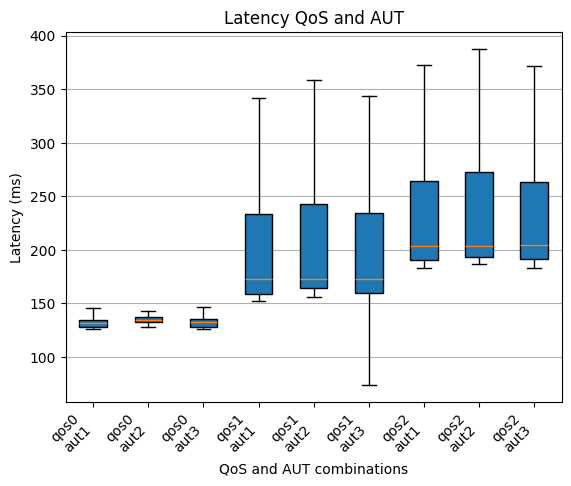

In [5]:
# Extract unique 'qos' values
qos_values = np.unique(np_array_global['qos'])

# Extract latency data for each 'qos' group
latency_data_by_qos = [np_array_global[np_array_global['qos'] == qos]['latency'] for qos in qos_values]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array_global[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array_global[(np_array_global['qos'] == qos) & (np_array_global['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

# Generate labels
labels = [f'{qos}\n{aut}' for qos, aut in unique_combinations]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
ax.boxplot(latency_data_by_combination, patch_artist=True, showfliers=False)

# Add grid lines
ax.yaxis.grid(True)

# Set labels and title
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('QoS and AUT combinations')
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency QoS and AUT')

# Display the plot
plt.show()

### Global Latency Filtered By QoS Level

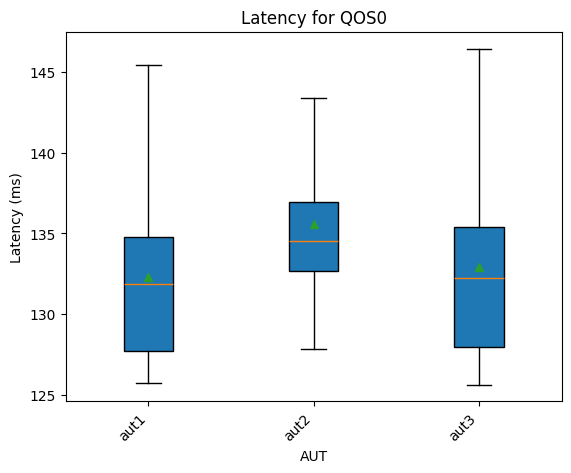

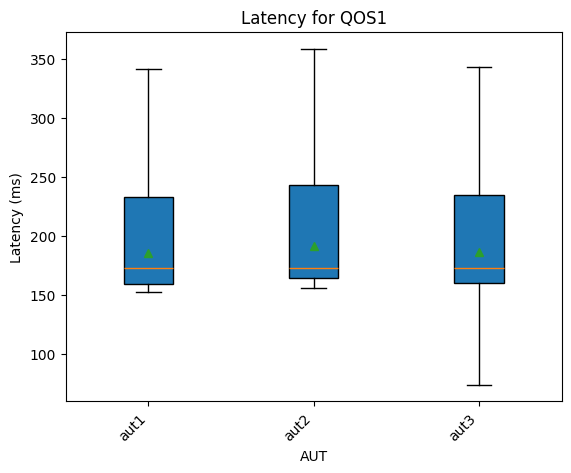

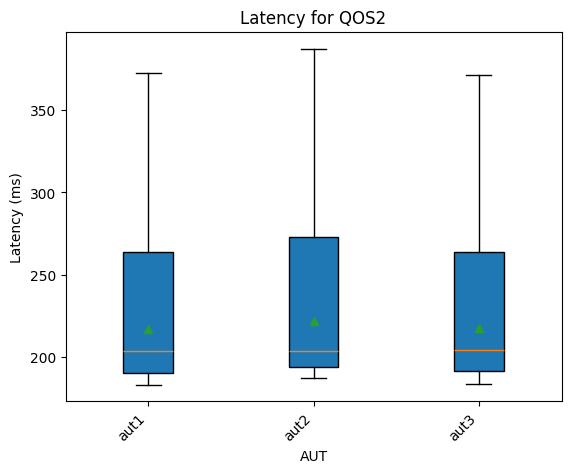

In [6]:
# Creating a plot for each unique 'qos' value
for qos in qoss:
    # Extract data for the current 'qos'
    data_for_qos = np_array_global[np_array_global['qos'] == qos]
    
    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        data_for_qos[data_for_qos['aut'] == aut]['latency']
        for aut in auts
    ]
    
    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True, showfliers=False,showmeans=True)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('AUT')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency for {qos.upper()}')
    
    # Display the plot
    plt.show()

# Build Sub Sets
Build the following sub-sets for each benchmark setup (AUT-QoS), based on filters applied to different columns of data
1. Per each repetion in the setup execution (10);
2. Per data Provider (2);
3. Per Gateway/Publisher (3);
4. Combination among the previous sets

In [7]:
execs_bounds=dict()
for aut in auts:
    for qos in qoss:
        aut_pub_log_folder = os.path.join(publishers_logs, aut, qos)
        
        if len(os.listdir(aut_pub_log_folder)) == 0:
            continue

        dates = logs_parser.get_pub_exec_datetimes(aut_pub_log_folder)
        index='.'.join((aut,qos))
        execs_bounds[index]=logs_parser.get_execs_bounds(dates)
    

for k,bounds in execs_bounds.items():
    sub_logs_per_execution_sets=list()
    for i,bound in enumerate(bounds):
        if i < (len(bounds)-1):
            sub_logs_per_execution_sets.append(logs_parser.get_bounded_sub_logs(np_array_global,bound,bounds[i+1]))
        else:
            sub_logs_per_execution_sets.append(logs_parser.get_bounded_sub_logs(np_array_global, bound))

    assert len(sub_logs_per_execution_sets) == logs_parser.NUM_RUNS

providers_sets= list()

for provider in providers_tp:
    subset = np_array_global[np.char.startswith(np_array_global['topic'], provider)]
    providers_sets.append(subset)

total_repetitions=sum([len(x) for x in execs_bounds.values()])

assert len(providers_sets) == len(providers_tp)

gateways_sets= list()
total_gateways_entries=0


for gateway in gateways:
    subset = np_array_global[np.char.startswith(np_array_global['gateway'], gateway)]
    total_gateways_entries+=len(subset)
    gateways_sets.append(subset)


total_repetitions=sum([len(x) for x in execs_bounds.values()])

assert len(providers_sets) == len(providers_tp)

assert len(gateways_sets) == len(gateways)

assert total_repetitions == logs_parser.NUM_RUNS*len(qoss)*len(auts)

assert total_log_entries == total_gateways_entries

## Results per Gateway (Sub Set  Grouped by Payload Sizes)

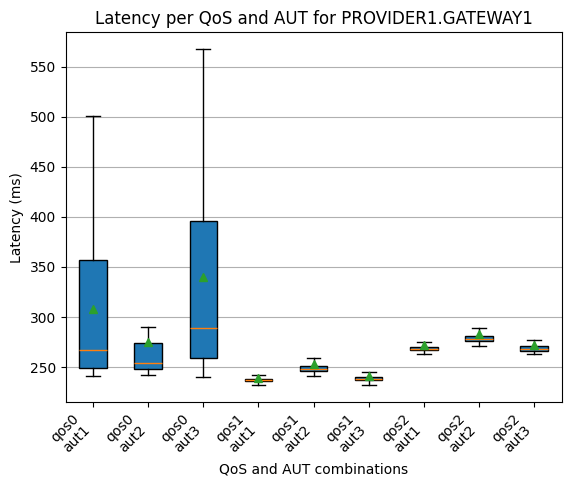

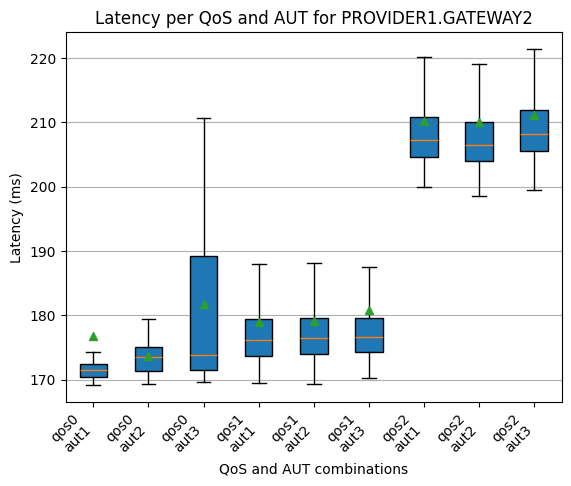

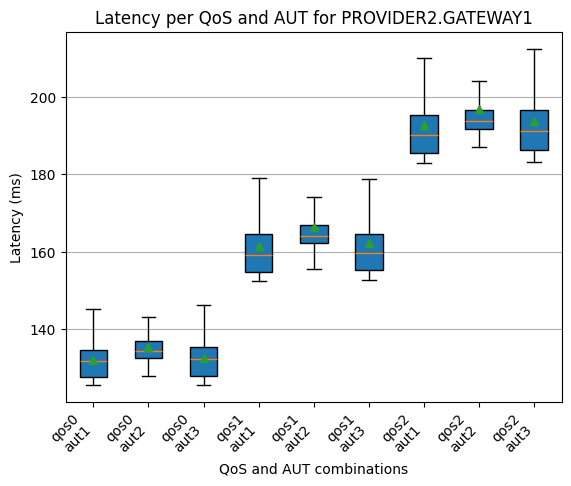

In [8]:
for i,subset in enumerate(gateways_sets):
    gateway=gateways[i]
    # Extract latency data for each 'qos' group
    latency_data_by_qos = [subset[subset['qos'] == qos]['latency'] for qos in qoss]
    
    # Extract unique combinations of 'qos' and 'aut'
    unique_combinations = np.unique(subset[['qos', 'aut']])
    
    # Extract latency data for each combination of 'qos' and 'aut'
    latency_data_by_combination = [
        subset[(subset['qos'] == qos) & (subset['aut'] == aut)]['latency']
        for qos, aut in unique_combinations
    ]
    
    # Generate labels
    labels = [f'{qos}\n{aut}' for qos, aut in unique_combinations]
    
    # Create a figure and an axis for the plot
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_combination, patch_artist=True, showfliers=False, showmeans=True)
    
    # Add grid lines
    ax.yaxis.grid(True)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('QoS and AUT combinations')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency per QoS and AUT for {gateway.upper()}')
    
    # Display the plot
    plt.show()

## Results for Gateway 1 - Provider 1 (Large Payload Size)

In [9]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider1.gateway1'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]   

for aut in auts:
    for qos in qoss:
        # Extract data for the current 'qos'
        data_for_qos = np_array[np_array['qos'] == qos]
        
        # Extract latency data for each 'aut' within the current 'qos'
        latency_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['latency']
    
        if len(latency_data_by_aut) == 0:
            continue
        
        delay = logs_parser.get_np_stats(latency_data_by_aut)
    
        rcv_msgs=len(latency_data_by_aut)
        avg_rcv_msgs = rcv_msgs/ logs_parser.NUM_RUNS
        
        # Extract uuid data for each 'aut' within the current 'qos'
        uuid_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['uuid']
        
        uniques = np.sum(np.unique_counts(uuid_data_by_aut).counts)
        duplicates_count = rcv_msgs - uniques
        avg_duplicates   = duplicates_count / logs_parser.NUM_RUNS
        
        lost_msgs=expected_msgs - rcv_msgs
        avg_lost_msg = (lost_msgs - duplicates_count)/ logs_parser.NUM_RUNS 
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        topic_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['topic_size']
        
        # Global topic sizes
        topic_size = logs_parser.get_np_stats(topic_size_data_by_aut)
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        payload_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['payload_size']
            
        
        # Global Payload sizes
        payload=logs_parser.get_np_stats(payload_size_data_by_aut)
        
        
        print(f'\n{aut.upper()}/{qos.upper()}\t\n')
        print(f'Total received msgs:{rcv_msgs}')
        print(f'Delay\tReceived Msg\tLost Msg\tDuplicated\tTopic')
        print(f'{delay["avg"]}\t{avg_rcv_msgs}\t{avg_lost_msg}\t{avg_duplicates}\t{topic_size["avg"]}')
        
        print(f'stdev_delay: {delay["stdev"]}')
        print(f'max_delay {delay["max"]}')
        print(f'min_delay {delay["min"]}')
        print(f'max_topic_size: {topic_size["max"]}')
        print(f'min_topic_size {topic_size["max"]}')
        print(f'avg_payload: {payload["avg"]}')
        print(f'p_stdev_payload: {payload["stdev"]}')
        print(f'p_max: {payload["max"]}')
        print(f'p_min: {payload["min"]}')


AUT1/QOS0	

Total received msgs:23
Delay	Received Msg	Lost Msg	Duplicated	Topic
307.65121858016306	2.3	997.7	0.0	15.0
stdev_delay: 75.13476157676502
max_delay 500.68115234375
min_delay 241.12109375
max_topic_size: 15
min_topic_size 15
avg_payload: 11076.0
p_stdev_payload: 0.0
p_max: 11076
p_min: 11076

AUT1/QOS1	

Total received msgs:10000
Delay	Received Msg	Lost Msg	Duplicated	Topic
239.21498146972655	1000.0	0.0	0.0	15.0
stdev_delay: 11.000221831000667
max_delay 774.236083984375
min_delay 230.275146484375
max_topic_size: 15
min_topic_size 15
avg_payload: 11076.0
p_stdev_payload: 0.0
p_max: 11076
p_min: 11076

AUT1/QOS2	

Total received msgs:10000
Delay	Received Msg	Lost Msg	Duplicated	Topic
271.8343634765625	1000.0	0.0	0.0	15.0
stdev_delay: 13.388666668575091
max_delay 731.404296875
min_delay 262.832763671875
max_topic_size: 15
min_topic_size 15
avg_payload: 11076.0
p_stdev_payload: 0.0
p_max: 11076
p_min: 11076

AUT2/QOS0	

Total received msgs:27
Delay	Received Msg	Lost Msg	Duplicat

### Box Plot for Gateway 1 - Provider 1 Results

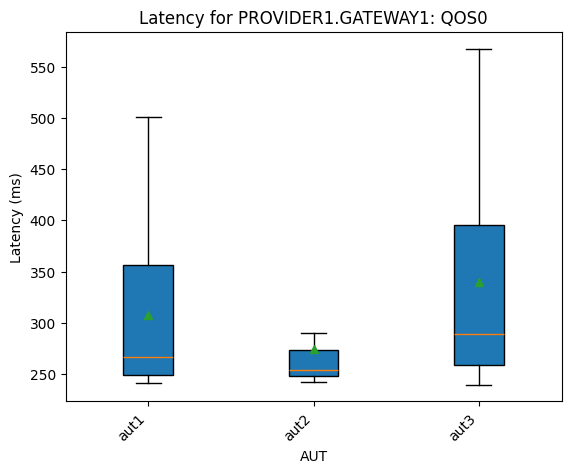

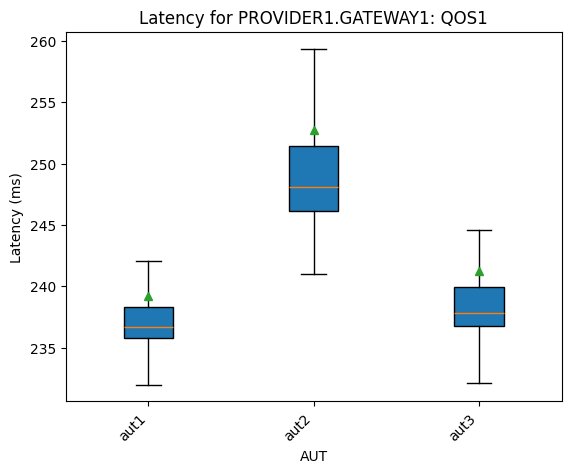

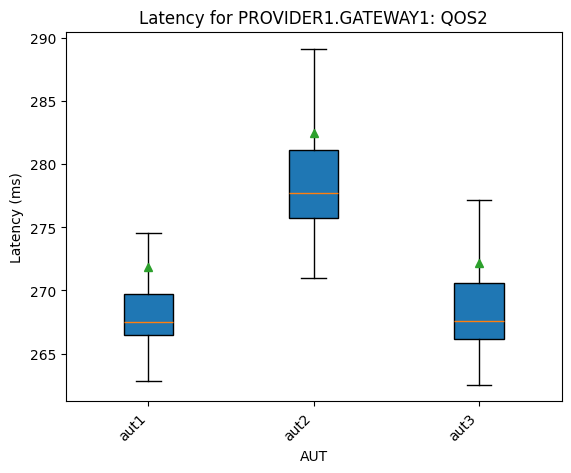

In [10]:
# Add grid lines
#ax.yaxis.grid(True)

# Creating a plot for each unique 'qos' value
for qos in qoss:
    # Extract data for the current 'qos'
    data_for_qos = np_array[np_array['qos'] == qos]
    
    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        data_for_qos[data_for_qos['aut'] == aut]['latency']
        for aut in auts
    ]
    
    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('AUT')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency for {gateway.upper()}: {qos.upper()}')

    # Save the figure to a PDF file
    plt.savefig(f"{gateway}-delay.pdf")

    # Display the plot
    plt.show()

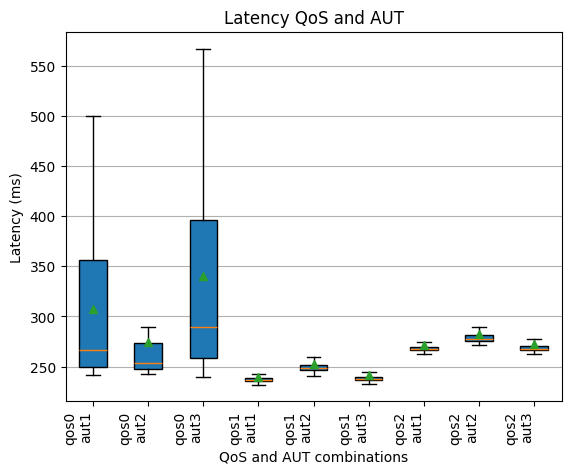

In [11]:
# Extract latency data for each 'qos' group
latency_data_by_qos = [np_array[np_array['qos'] == qos]['latency'] for qos in qoss]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

#loss_data_by_combination = = [
#    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
#    for qos, aut in unique_combinations
# ]

# Generate labels
labels = [f'{qos}\n{aut}' for qos, aut in unique_combinations]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
ax.boxplot(latency_data_by_combination, patch_artist=True, showfliers=False,showmeans=True)

# Add grid lines
ax.yaxis.grid(True)

# Set labels and title
ax.set_xticklabels(labels, rotation=90, ha='right')
ax.set_xlabel('QoS and AUT combinations')
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency QoS and AUT')

# Display the plot
plt.show()

### Latency and Reliability for Gateway 1 - Provider 1 (Figure 4)

/tmp/ipykernel_109440/2750545412.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s', label='Latency')
/tmp/ipykernel_109440/2750545412.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels)


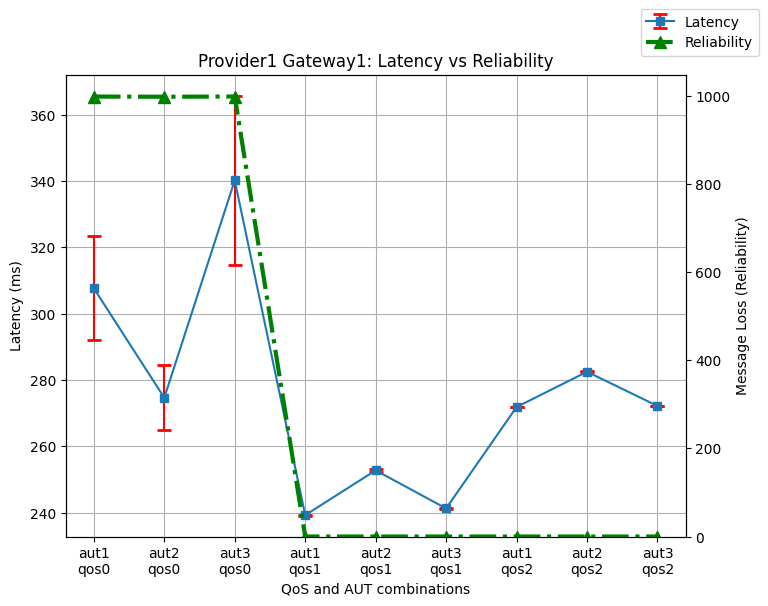

In [12]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider1.gateway1'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]   

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

# Calculate mean and standard error for each combination
means = [np.mean(sublist) for sublist in latency_data_by_combination]
errors = [np.std(sublist) / np.sqrt(len(sublist)) for sublist in latency_data_by_combination]

# Define x-coordinates (e.g., combination indices)
x = np.arange(len(latency_data_by_combination))

data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['uuid']
    for qos, aut in unique_combinations
]

# Create the error bar plot
#plt.figure(figsize=(8, 6))
#plt.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s')

# Generate labels
labels = [f'{aut}\n{qos}' for qos, aut in unique_combinations]

# Create the main plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Set labels and title
ax1.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s', label='Latency')
ax1.set_xticklabels(labels)
ax1.set_xlabel('QoS and AUT combinations')
ax1.set_ylabel('Latency (ms)')
ax1.set_xticks(x)
ax1.grid(True)
#plt.ylabel('Latency (ms)')

# Calculate message loss for each combination
loss=[((expected_msgs - len(sublist)) - (len(sublist) - (np.sum(np.unique_counts(sublist).counts))))
      / logs_parser.NUM_RUNS 
      for sublist in data_by_combination]

# print(loss)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data_by_combination_2
#ax2.bar(labels, loss, label='Reliability')
#ax2.plot(x, loss, label='Reliability')
ax2.errorbar(x, loss, color='green', linestyle='-.', marker='^',markersize=8,linewidth=3, label='Reliability')
ax2.set_ylabel('Message Loss (Reliability)')

# Set secondary y-axis to start at zero
ax2.set_ylim(bottom=0)


fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.set_title(f'{gateway.replace("."," ").title()}: Latency vs Reliability')
#plt.xticks(x, labels)
#plt.grid(True)

# Save the figure to a PDF file
plt.savefig(f"{gateway}.pdf")

# Display the plot
plt.show()

### Message Loss Results for Gateway 1 - Provider 1 (Figure 7)

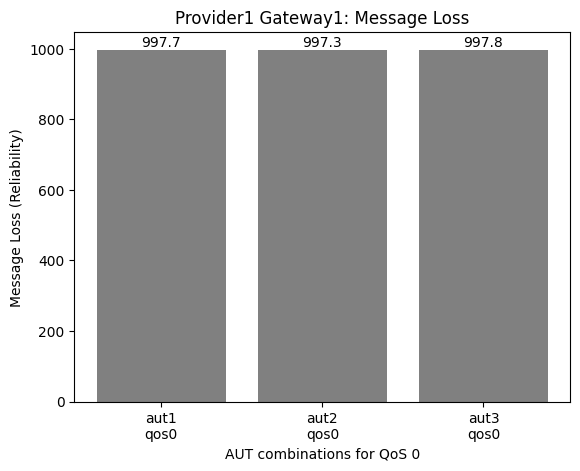

In [13]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider1.gateway1'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['uuid']
    for qos, aut in unique_combinations
]

# Generate labels
labels = [f'{aut}\n{qos}' for qos, aut in unique_combinations]

# Calculate message loss for each combination
loss=[((expected_msgs - len(sublist)) - (len(sublist) - (np.sum(np.unique_counts(sublist).counts))))
      / logs_parser.NUM_RUNS 
      for sublist in data_by_combination]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
bars = ax.bar(labels[0:3], loss[0:3], label='Reliability',color="grey")

# Annotate the bars with the mean values
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black')


# Set labels and title
ax.set_xlabel('AUT combinations for QoS 0')
ax.set_ylabel('Message Loss (Reliability)')
ax.set_title(f'{gateway.replace("."," ").title()}: Message Loss')


# Save the figure to a PDF file
plt.savefig(f"{gateway}-loss.pdf")

# Display the plot
plt.show()

## Results for Gateway 2 - Provider 1 (Medium Payload Size)

In [14]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider1.gateway2'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]   

for aut in auts:
    for qos in qoss:
        # Extract data for the current 'qos'
        data_for_qos = np_array[np_array['qos'] == qos]
        
        # Extract latency data for each 'aut' within the current 'qos'
        latency_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['latency']
    
        if len(latency_data_by_aut) == 0:
            continue
        
        delay = logs_parser.get_np_stats(latency_data_by_aut)
    
        rcv_msgs=len(latency_data_by_aut)
        avg_rcv_msgs = rcv_msgs/ logs_parser.NUM_RUNS
        
        # Extract uuid data for each 'aut' within the current 'qos'
        uuid_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['uuid']
        
        uniques = np.sum(np.unique_counts(uuid_data_by_aut).counts)
        duplicates_count = rcv_msgs - uniques
        avg_duplicates   = duplicates_count / logs_parser.NUM_RUNS
        
        lost_msgs=expected_msgs - rcv_msgs
        avg_lost_msg = (lost_msgs - duplicates_count)/ logs_parser.NUM_RUNS 
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        topic_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['topic_size']
        
        # Global topic sizes
        topic_size = logs_parser.get_np_stats(topic_size_data_by_aut)
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        payload_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['payload_size']
            
        
        # Global Payload sizes
        payload=logs_parser.get_np_stats(payload_size_data_by_aut)
        
        
        print(f'\n{aut.upper()}/{qos.upper()}\t\n')
        print(f'Total received msgs:{rcv_msgs}')
        print(f'Delay\tReceived Msg\tLost Msg\tDuplicated\tTopic')
        print(f'{delay["avg"]}\t{avg_rcv_msgs}\t{avg_lost_msg}\t{avg_duplicates}\t{topic_size["avg"]}')
        
        print(f'stdev_delay: {delay["stdev"]}')
        print(f'max_delay {delay["max"]}')
        print(f'min_delay {delay["min"]}')
        print(f'max_topic_size: {topic_size["max"]}')
        print(f'min_topic_size {topic_size["max"]}')
        print(f'avg_payload: {payload["avg"]}')
        print(f'p_stdev_payload: {payload["stdev"]}')
        print(f'p_max: {payload["max"]}')
        print(f'p_min: {payload["min"]}')


AUT1/QOS0	

Total received msgs:30
Delay	Received Msg	Lost Msg	Duplicated	Topic
176.78749186197916	3.0	997.0	0.0	15.0
stdev_delay: 26.86139699384375
max_delay 321.0634765625
min_delay 169.19091796875
max_topic_size: 15
min_topic_size 15
avg_payload: 9131.0
p_stdev_payload: 0.0
p_max: 9131
p_min: 9131

AUT1/QOS1	

Total received msgs:10000
Delay	Received Msg	Lost Msg	Duplicated	Topic
179.0329899169922	1000.0	0.0	0.0	15.0
stdev_delay: 20.88982400677773
max_delay 831.173583984375
min_delay 169.5166015625
max_topic_size: 15
min_topic_size 15
avg_payload: 9131.0
p_stdev_payload: 0.0
p_max: 9131
p_min: 9131

AUT1/QOS2	

Total received msgs:10000
Delay	Received Msg	Lost Msg	Duplicated	Topic
210.23407124023439	1000.0	0.0	0.0	15.0
stdev_delay: 13.753897386215476
max_delay 650.009521484375
min_delay 200.009521484375
max_topic_size: 15
min_topic_size 15
avg_payload: 9131.0
p_stdev_payload: 0.0
p_max: 9131
p_min: 9131

AUT2/QOS0	

Total received msgs:26
Delay	Received Msg	Lost Msg	Duplicated	Topi

### Box Plot for Gateway 2 - Provider 1 results

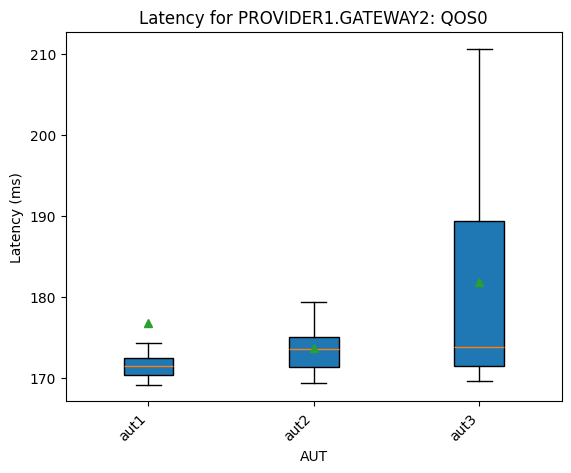

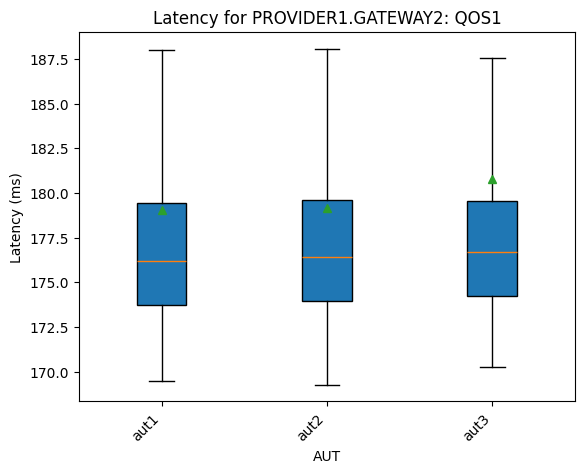

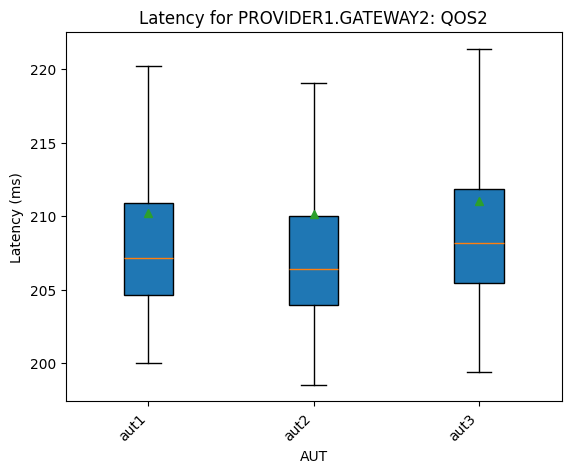

In [15]:
# Creating a plot for each unique 'qos' value
for qos in qoss:
    # Extract data for the current 'qos'
    data_for_qos = np_array[np_array['qos'] == qos]
    
    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        data_for_qos[data_for_qos['aut'] == aut]['latency']
        for aut in auts
    ]
    
    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('AUT')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency for {gateway.upper()}: {qos.upper()}')

    # Save the figure to a PDF file
    plt.savefig(f"{gateway}-delay.pdf")

    # Display the plot
    plt.show()

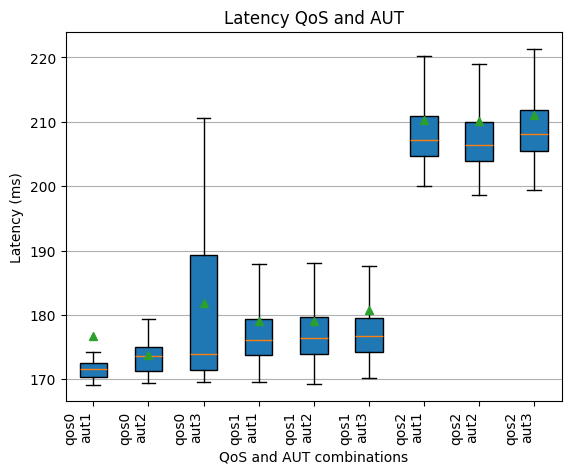

In [16]:
# Extract latency data for each 'qos' group
latency_data_by_qos = [np_array[np_array['qos'] == qos]['latency'] for qos in qoss]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

#loss_data_by_combination = = [
#    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
#    for qos, aut in unique_combinations
# ]

# Generate labels
labels = [f'{qos}\n{aut}' for qos, aut in unique_combinations]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
ax.boxplot(latency_data_by_combination, patch_artist=True, showfliers=False,showmeans=True)

# Add grid lines
ax.yaxis.grid(True)

# Set labels and title
ax.set_xticklabels(labels, rotation=90, ha='right')
ax.set_xlabel('QoS and AUT combinations')
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency QoS and AUT')

# Display the plot
plt.show()

### Latency and Reliability for Gateway 2 - Provider 1 (Figure 5)

/tmp/ipykernel_109440/1190453067.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s', label='Latency')
/tmp/ipykernel_109440/1190453067.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels)


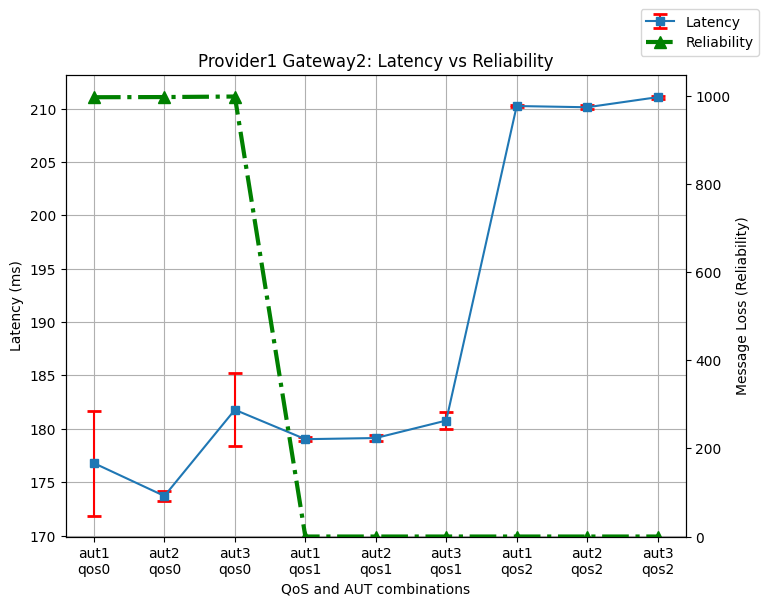

In [17]:
# Get data for all AUTs and QoS for provider 1, gateway 2
gateway='provider1.gateway2'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]   

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

# Calculate mean and standard error for each combination
means = [np.mean(sublist) for sublist in latency_data_by_combination]
errors = [np.std(sublist) / np.sqrt(len(sublist)) for sublist in latency_data_by_combination]

# Define x-coordinates (e.g., combination indices)
x = np.arange(len(latency_data_by_combination))

data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['uuid']
    for qos, aut in unique_combinations
]

# Create the error bar plot
#plt.figure(figsize=(8, 6))
#plt.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s')

# Generate labels
labels = [f'{aut}\n{qos}' for qos, aut in unique_combinations]

# Create the main plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Set labels and title
ax1.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s', label='Latency')
ax1.set_xticklabels(labels)
ax1.set_xlabel('QoS and AUT combinations')
ax1.set_ylabel('Latency (ms)')
ax1.set_xticks(x)
ax1.grid(True)
#plt.ylabel('Latency (ms)')

# Calculate message loss for each combination
loss=[((expected_msgs - len(sublist)) - (len(sublist) - (np.sum(np.unique_counts(sublist).counts))))
      / logs_parser.NUM_RUNS 
      for sublist in data_by_combination]

# print(loss)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data_by_combination_2
#ax2.bar(labels, loss, label='Reliability')
#ax2.plot(x, loss, label='Reliability')
ax2.errorbar(x, loss, color='green', linestyle='-.', marker='^',markersize=8,linewidth=3, label='Reliability')
ax2.set_ylabel('Message Loss (Reliability)')

# Set secondary y-axis to start at zero
ax2.set_ylim(bottom=0)


fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.set_title(f'{gateway.replace("."," ").title()}: Latency vs Reliability')
#plt.xticks(x, labels)
#plt.grid(True)

# Save the figure to a PDF file
plt.savefig(f"{gateway}.pdf")

# Display the plot
plt.show()

### Message Loss Results for Gateway 2 - Provider 1 (Figure 8)

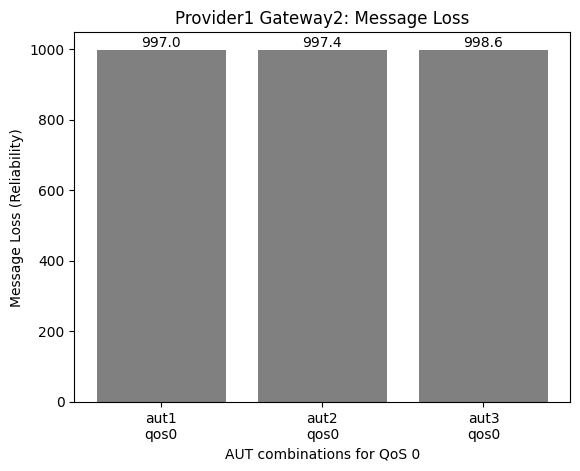

In [18]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider1.gateway2'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['uuid']
    for qos, aut in unique_combinations
]

# Generate labels
labels = [f'{aut}\n{qos}' for qos, aut in unique_combinations]

# Calculate message loss for each combination
loss=[((expected_msgs - len(sublist)) - (len(sublist) - (np.sum(np.unique_counts(sublist).counts))))
      / logs_parser.NUM_RUNS 
      for sublist in data_by_combination]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
bars = ax.bar(labels[0:3], loss[0:3], label='Reliability',color="grey")

# Annotate the bars with the mean values
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black')


# Set labels and title
ax.set_xlabel('AUT combinations for QoS 0')
ax.set_ylabel('Message Loss (Reliability)')
ax.set_title(f'{gateway.replace("."," ").title()}: Message Loss')


# Save the figure to a PDF file
plt.savefig(f"{gateway}-loss.pdf")

# Display the plot
plt.show()

## Results for Gateway 1 - Provider 2 (Small Payload Size)

In [19]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider2.gateway1'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]   

for aut in auts:
    for qos in qoss:
        # Extract data for the current 'qos'
        data_for_qos = np_array[np_array['qos'] == qos]
        
        # Extract latency data for each 'aut' within the current 'qos'
        latency_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['latency']
    
        if len(latency_data_by_aut) == 0:
            continue
        
        delay = logs_parser.get_np_stats(latency_data_by_aut)
    
        rcv_msgs=len(latency_data_by_aut)
        avg_rcv_msgs = rcv_msgs/ logs_parser.NUM_RUNS
        
        # Extract uuid data for each 'aut' within the current 'qos'
        uuid_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['uuid']
        
        uniques = np.sum(np.unique_counts(uuid_data_by_aut).counts)
        duplicates_count = rcv_msgs - uniques
        avg_duplicates   = duplicates_count / logs_parser.NUM_RUNS
        
        lost_msgs=expected_msgs - rcv_msgs
        avg_lost_msg = (lost_msgs - duplicates_count)/ logs_parser.NUM_RUNS 
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        topic_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['topic_size']
        
        # Global topic sizes
        topic_size = logs_parser.get_np_stats(topic_size_data_by_aut)
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        payload_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['payload_size']
            
        
        # Global Payload sizes
        payload=logs_parser.get_np_stats(payload_size_data_by_aut)
        
        
        print(f'\n{aut.upper()}/{qos.upper()}\t\n')
        print(f'Delay\tReceived Msg\tLost Msg\tDuplicated\tTopic')
        print(f'{delay["avg"]}\t{avg_rcv_msgs}\t{avg_lost_msg}\t{avg_duplicates}\t{topic_size["avg"]}')
        
        print(f'stdev_delay: {delay["stdev"]}')
        print(f'max_delay {delay["max"]}')
        print(f'min_delay {delay["min"]}')
        print(f'max_topic_size: {topic_size["max"]}')
        print(f'min_topic_size {topic_size["max"]}')
        print(f'avg_payload: {payload["avg"]}')
        print(f'p_stdev_payload: {payload["stdev"]}')
        print(f'p_max: {payload["max"]}')
        print(f'p_min: {payload["min"]}')


AUT1/QOS0	

Delay	Received Msg	Lost Msg	Duplicated	Topic
132.0289054487781	1998.9	1.1	0.0	15.0
stdev_delay: 6.508831683827564
max_delay 545.77880859375
min_delay 125.759521484375
max_topic_size: 15
min_topic_size 15
avg_payload: 1020.7765270898994
p_stdev_payload: 502.4999239131967
p_max: 1523
p_min: 518

AUT1/QOS1	

Delay	Received Msg	Lost Msg	Duplicated	Topic
161.4104171875	2000.0	0.0	0.0	15.0
stdev_delay: 16.195593205008944
max_delay 894.47607421875
min_delay 152.593017578125
max_topic_size: 15
min_topic_size 15
avg_payload: 1020.5
p_stdev_payload: 502.5
p_max: 1523
p_min: 518

AUT1/QOS2	

Delay	Received Msg	Lost Msg	Duplicated	Topic
192.76710778808595	2000.0	0.0	0.0	15.0
stdev_delay: 12.178973890619227
max_delay 591.8369140625
min_delay 182.941650390625
max_topic_size: 15
min_topic_size 15
avg_payload: 1020.5
p_stdev_payload: 502.5
p_max: 1523
p_min: 518

AUT2/QOS0	

Delay	Received Msg	Lost Msg	Duplicated	Topic
135.3464778080885	1999.4	0.6	0.0	29.0
stdev_delay: 4.940302257576886
m

### Box Plot for Gateway 1 - Provider 2 Results

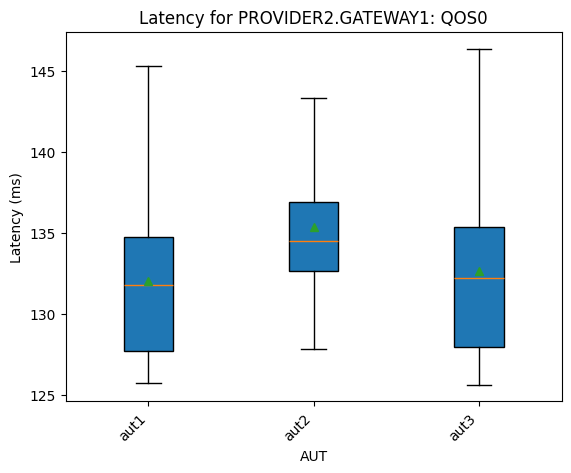

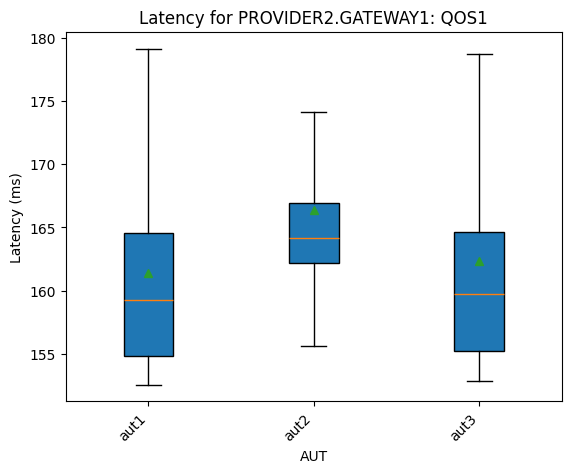

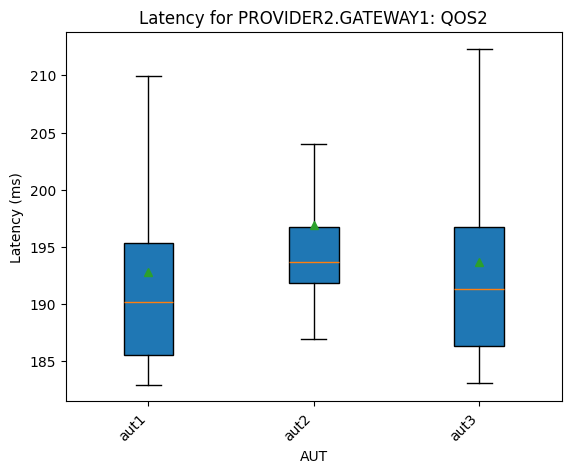

In [20]:
# Creating a plot for each unique 'qos' value
for qos in qoss:
    # Extract data for the current 'qos'
    data_for_qos = np_array[np_array['qos'] == qos]
    
    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        data_for_qos[data_for_qos['aut'] == aut]['latency']
        for aut in auts
    ]
    
    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('AUT')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency for {gateway.upper()}: {qos.upper()}')

    # Save the figure to a PDF file
    plt.savefig(f"{gateway}-delay.pdf")

    # Display the plot
    plt.show()

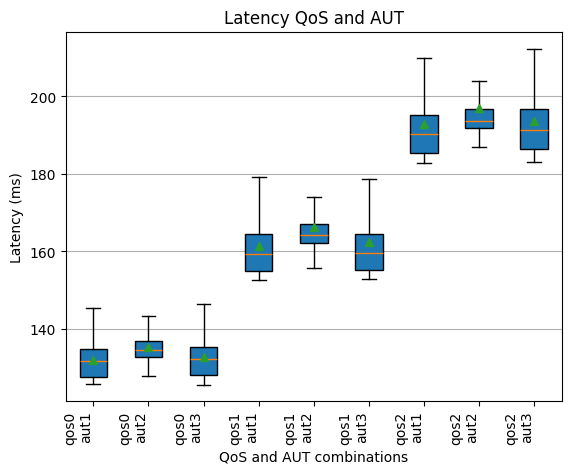

In [21]:
# Extract latency data for each 'qos' group
latency_data_by_qos = [np_array[np_array['qos'] == qos]['latency'] for qos in qoss]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

#loss_data_by_combination = = [
#    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
#    for qos, aut in unique_combinations
# ]

# Generate labels
labels = [f'{qos}\n{aut}' for qos, aut in unique_combinations]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
ax.boxplot(latency_data_by_combination, patch_artist=True, showfliers=False,showmeans=True)

# Add grid lines
ax.yaxis.grid(True)

# Set labels and title
ax.set_xticklabels(labels, rotation=90, ha='right')
ax.set_xlabel('QoS and AUT combinations')
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency QoS and AUT')

# Display the plot
plt.show()

### Latency and Reliability for Gateway 1 - Provider 2 (Figure 6)

/tmp/ipykernel_109440/3656641990.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s', label='Latency')
/tmp/ipykernel_109440/3656641990.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels)


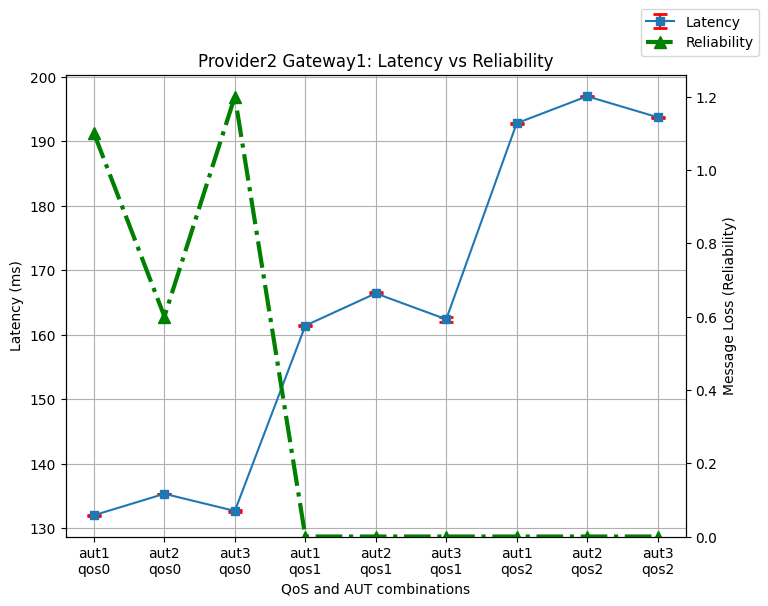

In [22]:
# Get data for all AUTs and QoS for provider 2, gateway 1
gateway='provider2.gateway1'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]   

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

# Extract latency data for each combination of 'qos' and 'aut'
latency_data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['latency']
    for qos, aut in unique_combinations
]

# Calculate mean and standard error for each combination
means = [np.mean(sublist) for sublist in latency_data_by_combination]
errors = [np.std(sublist) / np.sqrt(len(sublist)) for sublist in latency_data_by_combination]

# Define x-coordinates (e.g., combination indices)
x = np.arange(len(latency_data_by_combination))

data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['uuid']
    for qos, aut in unique_combinations
]

# Create the error bar plot
#plt.figure(figsize=(8, 6))
#plt.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s')

# Generate labels
labels = [f'{aut}\n{qos}' for qos, aut in unique_combinations]

# Create the main plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Set labels and title
ax1.errorbar(x, means, yerr=errors, fmt='o', capsize=5, capthick=2, ecolor='red', linestyle='-', marker='s', label='Latency')
ax1.set_xticklabels(labels)
ax1.set_xlabel('QoS and AUT combinations')
ax1.set_ylabel('Latency (ms)')
ax1.set_xticks(x)
ax1.grid(True)
#plt.ylabel('Latency (ms)')

# Calculate message loss for each combination
loss=[((expected_msgs - len(sublist)) - (len(sublist) - (np.sum(np.unique_counts(sublist).counts))))
      / logs_parser.NUM_RUNS 
      for sublist in data_by_combination]

# print(loss)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data_by_combination_2
#ax2.bar(labels, loss, label='Reliability')
#ax2.plot(x, loss, label='Reliability')
ax2.errorbar(x, loss, color='green', linestyle='-.', marker='^',markersize=8,linewidth=3, label='Reliability')
ax2.set_ylabel('Message Loss (Reliability)')

# Set secondary y-axis to start at zero
ax2.set_ylim(bottom=0)


fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.set_title(f'{gateway.replace("."," ").title()}: Latency vs Reliability')
#plt.xticks(x, labels)
#plt.grid(True)

# Save the figure to a PDF file
plt.savefig(f"{gateway}.pdf")

# Display the plot
plt.show()

### Message Loss Results for Gateway 2 - Provider 1 (Figure 9)

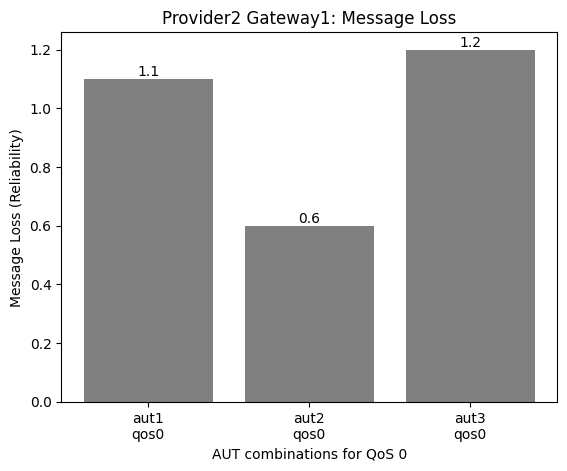

In [23]:
# Get data for all AUTs and QoS for provider 1, gateway 1
gateway='provider2.gateway1'

expected_msgs=0

if 'provider1' in gateway:
    expected_msgs=10000
elif 'provider2' in gateway:
    expected_msgs=20000

np_array=gateways_sets[gateways.index(gateway)]

# Extract unique combinations of 'qos' and 'aut'
unique_combinations = np.unique(np_array[['qos', 'aut']])

data_by_combination = [
    np_array[(np_array['qos'] == qos) & (np_array['aut'] == aut)]['uuid']
    for qos, aut in unique_combinations
]

# Generate labels
labels = [f'{aut}\n{qos}' for qos, aut in unique_combinations]

# Calculate message loss for each combination
loss=[((expected_msgs - len(sublist)) - (len(sublist) - (np.sum(np.unique_counts(sublist).counts))))
      / logs_parser.NUM_RUNS 
      for sublist in data_by_combination]

# Create a figure and an axis for the plot
fig, ax = plt.subplots()

# Create the boxplot
bars = ax.bar(labels[0:3], loss[0:3], label='Reliability',color="grey")

# Annotate the bars with the mean values
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black')


# Set labels and title
ax.set_xlabel('AUT combinations for QoS 0')
ax.set_ylabel('Message Loss (Reliability)')
ax.set_title(f'{gateway.replace("."," ").title()}: Message Loss')


# Save the figure to a PDF file
plt.savefig(f"{gateway}-loss.pdf")

# Display the plot
plt.show()

# Topic Overhead

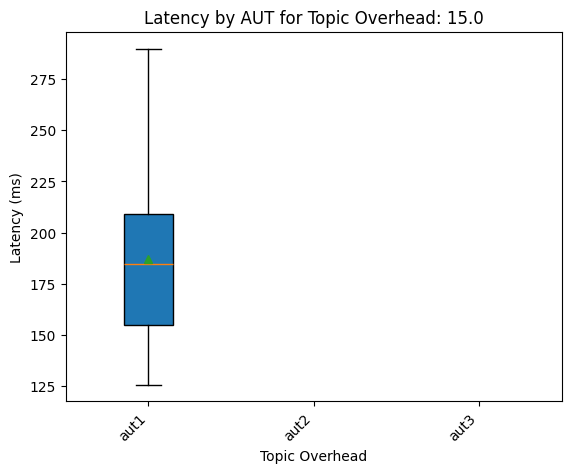

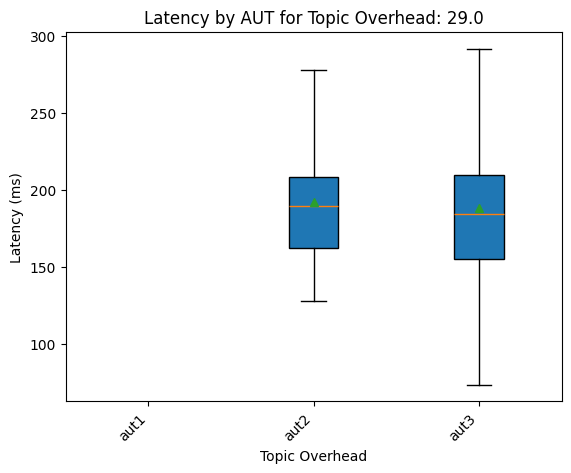

In [24]:
topic_overheads =[15.0, 29.0]
topics_overhead_sets=list()
for topic_overhead in topic_overheads:
    subset = np_array_global[np_array_global['topic_size'] == topic_overhead]
    topics_overhead_sets.append(subset)

    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        subset[subset['aut'] == aut]['latency']
        for aut in auts
    ]

    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Topic Overhead')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency by AUT for Topic Overhead: {str(topic_overhead)}')

    # Display the plot
    plt.show()

## Latency per Gateway

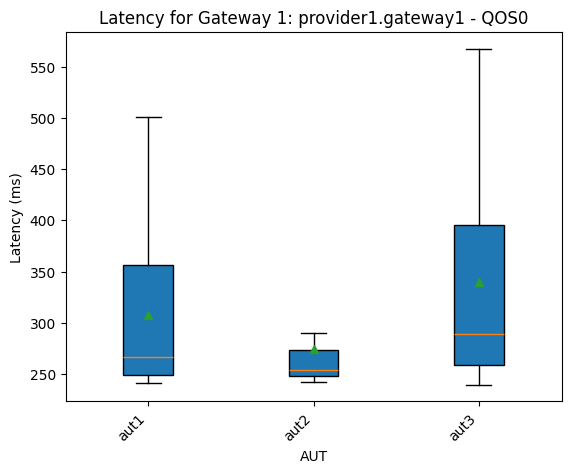

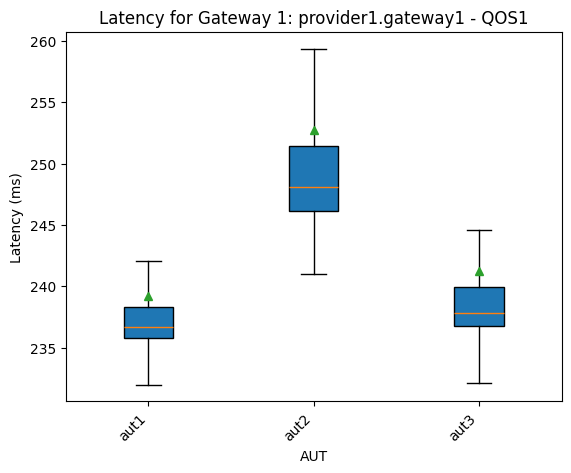

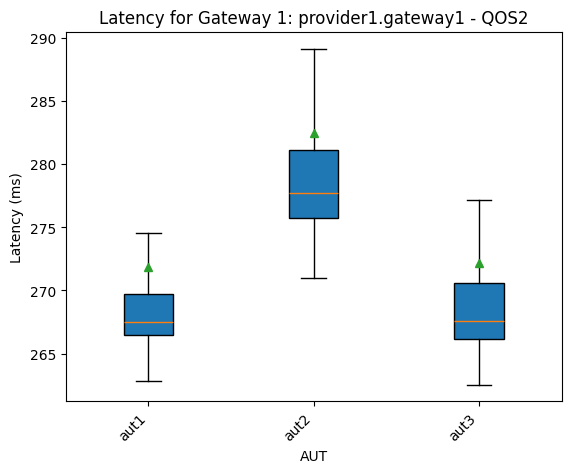

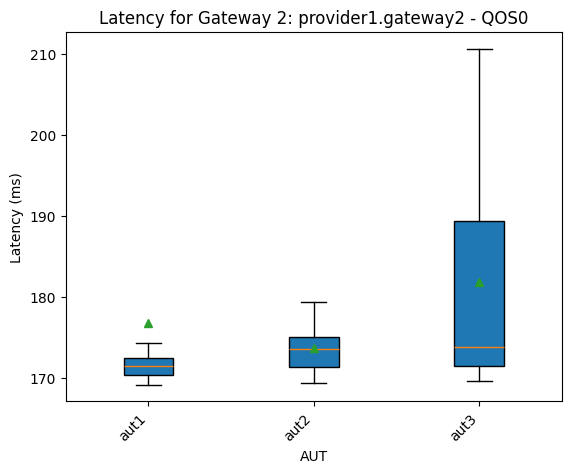

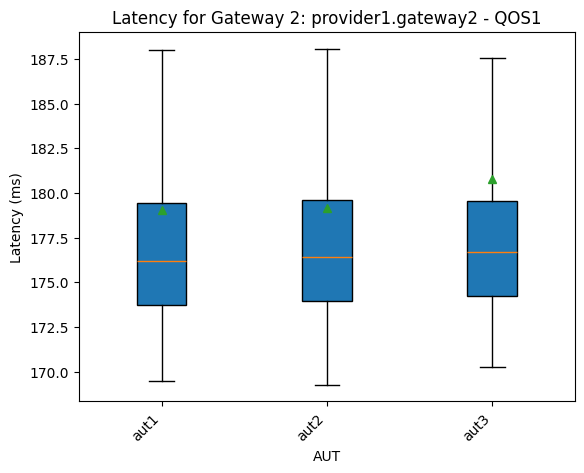

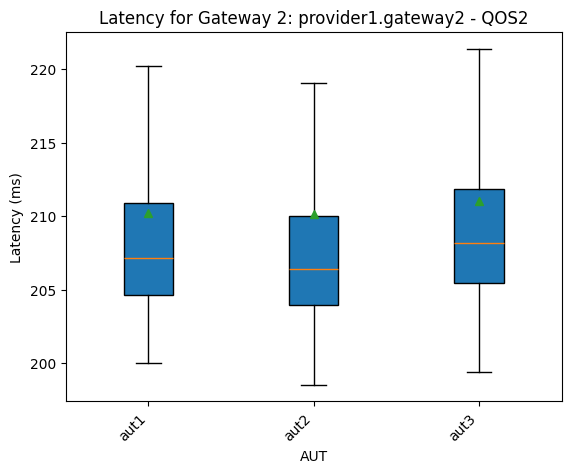

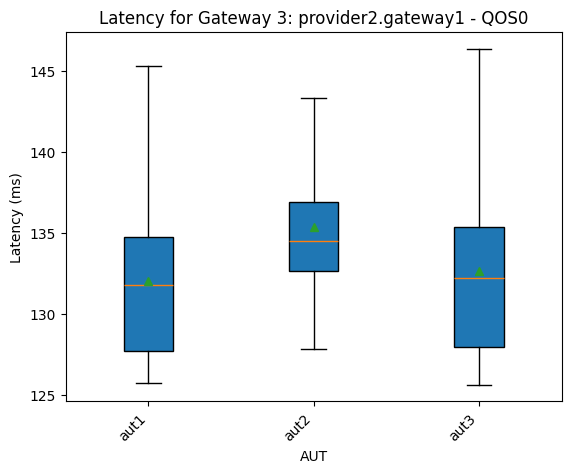

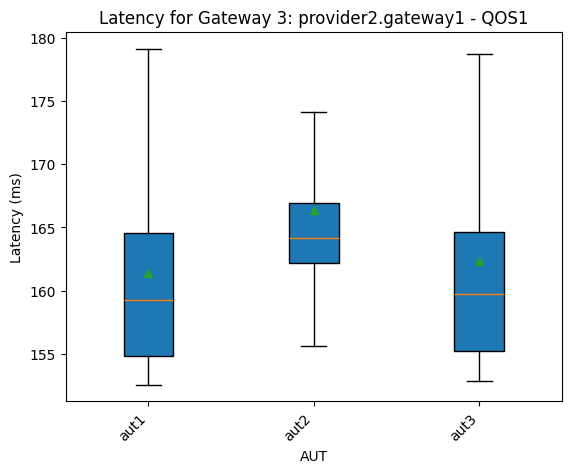

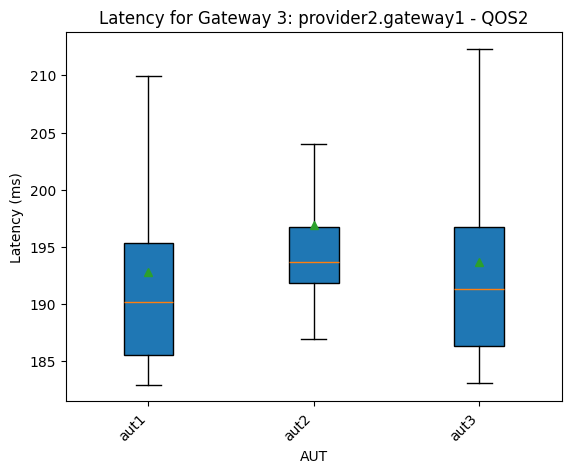

In [25]:
#for provider,np_array in providers_sets.items():
    # basic plot

for i,gateway in enumerate(gateways):
    np_array= gateways_sets[i]
    
    # Add grid lines
    #ax.yaxis.grid(True)
    
    # Creating a plot for each unique 'qos' value
    for qos in qoss:
        # Extract data for the current 'qos'
        data_for_qos = np_array[np_array['qos'] == qos]
        
        # Extract latency data for each 'aut' within the current 'qos'
        latency_data_by_aut = [
            data_for_qos[data_for_qos['aut'] == aut]['latency']
            for aut in auts
        ]
        
        # Generate labels for the x-axis based on 'aut'
        labels = [f'{aut}' for aut in auts]
        
        # Create a figure and an axis for the current 'qos'
        fig, ax = plt.subplots()
        
        # Create the boxplot
        ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
        
        # Set labels and title
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_xlabel('AUT')
        ax.set_ylabel('Latency (ms)')
        ax.set_title(f'Latency for Gateway {str(i+1)}: {gateways[i]} - {qos.upper()}')
    
        # Display the plot
        plt.show()

# Results Plots

## Latency Plots for Provider 1

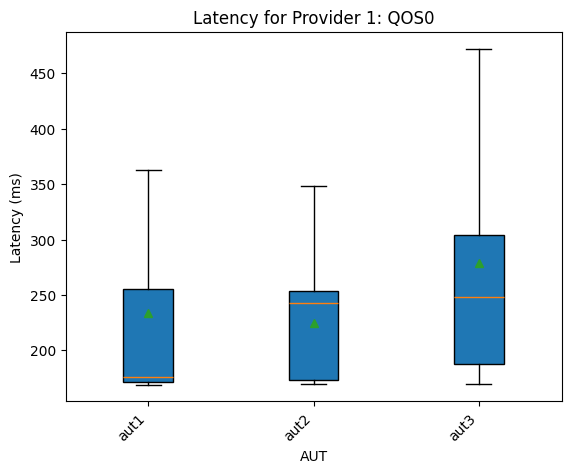

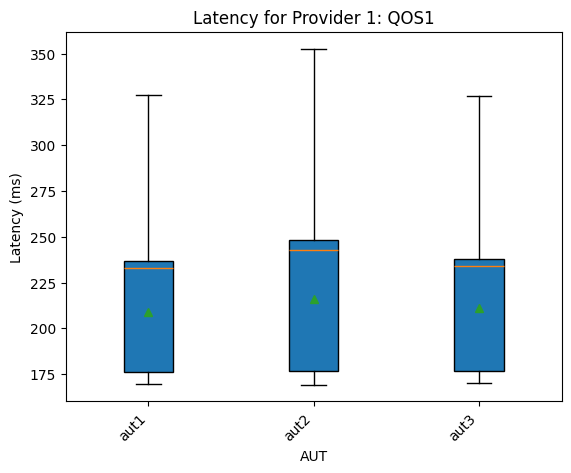

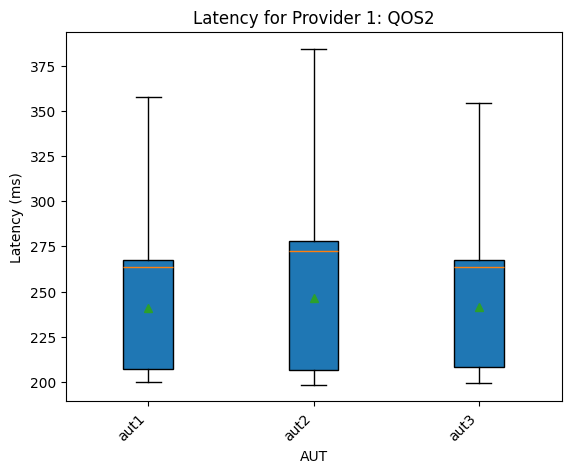

In [26]:
#for provider,np_array in providers_sets.items():
    # basic plot

np_array= providers_sets[0]

# Add grid lines
#ax.yaxis.grid(True)

# Creating a plot for each unique 'qos' value
for qos in qoss:
    # Extract data for the current 'qos'
    data_for_qos = np_array[np_array['qos'] == qos]
    
    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        data_for_qos[data_for_qos['aut'] == aut]['latency']
        for aut in auts
    ]
    
    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('AUT')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency for Provider 1: {qos.upper()}')

    # Display the plot
    plt.show()

# Results Provider 1

In [27]:
# Stats

# Get data for all AUTs and QoS for provider 1
np_array= providers_sets[0]

for aut in auts:
    for qos in qoss:
        # Extract data for the current 'qos'
        data_for_qos = np_array[np_array['qos'] == qos]
        
        # Extract latency data for each 'aut' within the current 'qos'
        latency_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['latency']
    
        if len(latency_data_by_aut) == 0:
            continue
        
        delay = logs_parser.get_np_stats(latency_data_by_aut)
    
        rcv_msgs=len(latency_data_by_aut)
        avg_rcv_msgs = rcv_msgs/ logs_parser.NUM_RUNS
        
        # Extract uuid data for each 'aut' within the current 'qos'
        uuid_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['uuid']
        
        uniques = np.sum(np.unique_counts(uuid_data_by_aut).counts)
        duplicates_count = rcv_msgs - uniques
        avg_duplicates   = duplicates_count / logs_parser.NUM_RUNS
        
        lost_msgs=logs_parser.get_lost_messages(load)
        avg_lost_msg = (lost_msgs - duplicates_count)/ logs_parser.NUM_RUNS 
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        topic_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['topic_size']
        
        # Global topic sizes
        topic_size = logs_parser.get_np_stats(topic_size_data_by_aut)
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        payload_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['payload_size']
            
        
        # Global Payload sizes
        payload=logs_parser.get_np_stats(payload_size_data_by_aut)
        
        
        print(f'\n{aut.upper()}/{qos.upper()}\t\n')
        print(f'Delay\tReceived Msg\tLost Msg\tDuplicated\tTopic')
        print(f'{delay["avg"]}\t{avg_rcv_msgs}\t{avg_lost_msg}\t{avg_duplicates}\t{topic_size["avg"]}')
        
        print(f'stdev_delay: {delay["stdev"]}')
        print(f'max_delay {delay["max"]}')
        print(f'min_delay {delay["min"]}')
        print(f'max_topic_size: {topic_size["max"]}')
        print(f'min_topic_size {topic_size["max"]}')
        print(f'avg_payload: {payload["avg"]}')
        print(f'p_stdev_payload: {payload["stdev"]}')
        print(f'p_max: {payload["max"]}')
        print(f'p_min: {payload["min"]}')
        


AUT1/QOS0	

Delay	Received Msg	Lost Msg	Duplicated	Topic
233.57741100383254	5.3	0.0	0.0	15.0
stdev_delay: 84.05283584916374
max_delay 500.68115234375
min_delay 169.19091796875
max_topic_size: 15
min_topic_size 15
avg_payload: 9975.056603773584
p_stdev_payload: 963.9805724006183
p_max: 11076
p_min: 9131

AUT1/QOS1	

Delay	Received Msg	Lost Msg	Duplicated	Topic
209.12398569335937	2000.0	0.0	0.0	15.0
stdev_delay: 34.41166721471125
max_delay 831.173583984375
min_delay 169.5166015625
max_topic_size: 15
min_topic_size 15
avg_payload: 10103.5
p_stdev_payload: 972.5
p_max: 11076
p_min: 9131

AUT1/QOS2	

Delay	Received Msg	Lost Msg	Duplicated	Topic
241.03421735839845	2000.0	0.0	0.0	15.0
stdev_delay: 33.658016060615275
max_delay 731.404296875
min_delay 200.009521484375
max_topic_size: 15
min_topic_size 15
avg_payload: 10103.5
p_stdev_payload: 972.5
p_max: 11076
p_min: 9131

AUT2/QOS0	

Delay	Received Msg	Lost Msg	Duplicated	Topic
225.12885097287736	5.3	0.0	0.0	29.0
stdev_delay: 62.3427668451269

## Latency Plots for Provider 2

19994


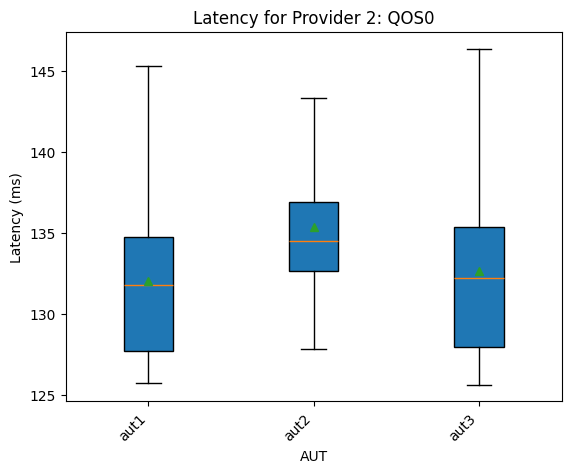

20000


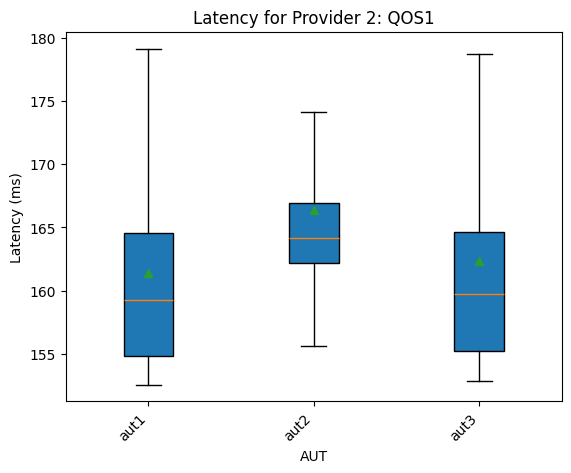

20000


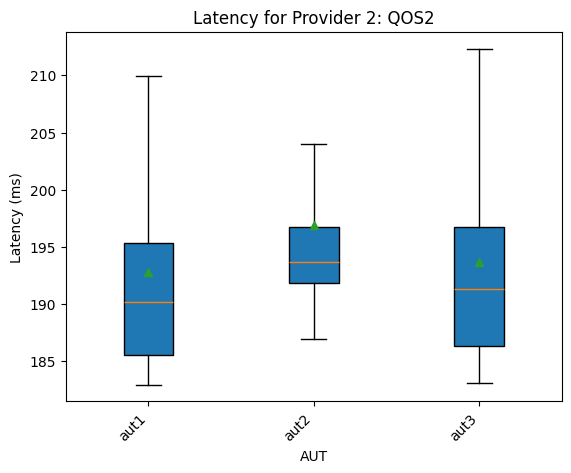

In [28]:
np_array= providers_sets[1]

# Add grid lines
#ax.yaxis.grid(True)

# Creatingfor each unique 'qos' value
for qos in qoss:
    # Extract data for the current 'qos'
    data_for_qos = np_array[np_array['qos'] == qos]
    
    # Extract latency data for each 'aut' within the current 'qos'
    latency_data_by_aut = [
        data_for_qos[data_for_qos['aut'] == aut]['latency']
        for aut in auts
    ]

    print(len(latency_data_by_aut[1]))
    
    # Generate labels for the x-axis based on 'aut'
    labels = [f'{aut}' for aut in auts]
    
    # Create a figure and an axis for the current 'qos'
    fig, ax = plt.subplots()
    
    # Create the boxplot
    ax.boxplot(latency_data_by_aut, patch_artist=True,showmeans=True,showfliers=False)
    
    # Set labels and title
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('AUT')
    ax.set_ylabel('Latency (ms)')
    ax.set_title(f'Latency for Provider 2: {qos.upper()}')
    
    # Display the plot
    plt.show()

# Results Provider 2

In [29]:
# Stats

# Get data for all AUTs and QoS for provider 1
np_array= providers_sets[1]

for aut in auts:
    for qos in qoss:
        # Extract data for the current 'qos'
        data_for_qos = np_array[np_array['qos'] == qos]
        
        # Extract latency data for each 'aut' within the current 'qos'
        latency_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['latency']

        if len(latency_data_by_aut) == 0:
            continue
        
        delay = logs_parser.get_np_stats(latency_data_by_aut)
    
        rcv_msgs=len(latency_data_by_aut)
        avg_rcv_msgs = rcv_msgs/ logs_parser.NUM_RUNS
        
        # Extract uuid data for each 'aut' within the current 'qos'
        uuid_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['uuid']
        
        uniques = np.sum(np.unique_counts(uuid_data_by_aut).counts)
        duplicates_count = rcv_msgs - uniques
        avg_duplicates   = duplicates_count / logs_parser.NUM_RUNS
        
        lost_msgs=logs_parser.get_lost_messages(load)
        avg_lost_msg = (lost_msgs - duplicates_count)/ logs_parser.NUM_RUNS 
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        topic_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['topic_size']
        
        # Global topic sizes
        topic_size = logs_parser.get_np_stats(topic_size_data_by_aut)
        
        # Extract uuid data for each 'topic_size' within the current 'qos'
        payload_size_data_by_aut = data_for_qos[data_for_qos['aut'] == aut]['payload_size']
            
        
        # Global Payload sizes
        payload=logs_parser.get_np_stats(payload_size_data_by_aut)
        
        
        print(f'\n{aut.upper()}/{qos.upper()}\t\n')
        print(f'Delay\tReceived Msg\tLost Msg\tDuplicated\tTopic')
        print(f'{delay["avg"]}\t{avg_rcv_msgs}\t{avg_lost_msg}\t{avg_duplicates}\t{topic_size["avg"]}')
        
        print(f'stdev_delay: {delay["stdev"]}')
        print(f'max_delay {delay["max"]}')
        print(f'min_delay {delay["min"]}')
        print(f'max_topic_size: {topic_size["max"]}')
        print(f'min_topic_size {topic_size["max"]}')
        print(f'avg_payload: {payload["avg"]}')
        print(f'p_stdev_payload: {payload["stdev"]}')
        print(f'p_max: {payload["max"]}')
        print(f'p_min: {payload["min"]}')
        


AUT1/QOS0	

Delay	Received Msg	Lost Msg	Duplicated	Topic
132.0289054487781	1998.9	0.0	0.0	15.0
stdev_delay: 6.508831683827564
max_delay 545.77880859375
min_delay 125.759521484375
max_topic_size: 15
min_topic_size 15
avg_payload: 1020.7765270898994
p_stdev_payload: 502.4999239131967
p_max: 1523
p_min: 518

AUT1/QOS1	

Delay	Received Msg	Lost Msg	Duplicated	Topic
161.4104171875	2000.0	0.0	0.0	15.0
stdev_delay: 16.195593205008944
max_delay 894.47607421875
min_delay 152.593017578125
max_topic_size: 15
min_topic_size 15
avg_payload: 1020.5
p_stdev_payload: 502.5
p_max: 1523
p_min: 518

AUT1/QOS2	

Delay	Received Msg	Lost Msg	Duplicated	Topic
192.76710778808595	2000.0	0.0	0.0	15.0
stdev_delay: 12.178973890619227
max_delay 591.8369140625
min_delay 182.941650390625
max_topic_size: 15
min_topic_size 15
avg_payload: 1020.5
p_stdev_payload: 502.5
p_max: 1523
p_min: 518

AUT2/QOS0	

Delay	Received Msg	Lost Msg	Duplicated	Topic
135.3464778080885	1999.4	0.0	0.0	29.0
stdev_delay: 4.940302257576886
m